## DQN algorithm: Double DQN

In [7]:
import gym

# 定义环境
class MyWrapper(gym.Wrapper):
  def __init__(self):
    env = gym.make('Pendulum-v1', render_mode='rgb_array')
    super().__init__(env)
    self.env = env
    self.step_n = 0
  
  def reset(self):
    state, _ = self.env.reset()
    self.step_n = 0
    return state
    
  def step(self, action):
    state, reward, terminated, truncated, info = self.env.step(action)
    done = terminated or truncated
    self.step_n += 1
    if self.step_n >= 200:
      done = True
    return state, reward, done, info 
  
env = MyWrapper()
env.reset()

array([-0.7351283 , -0.67792803,  0.85054547], dtype=float32)

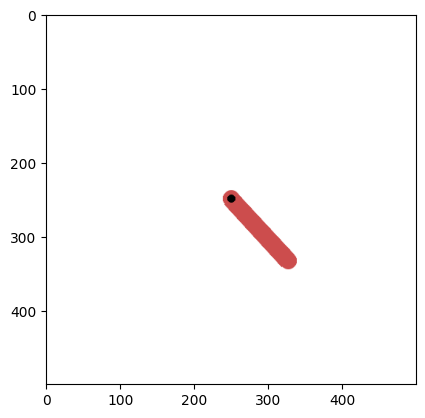

In [8]:
from matplotlib import pyplot as plt

%matplotlib inline

# 打印游戏
def show():
  plt.imshow(env.render())
  plt.show()
  
show()

In [9]:
# 测试游戏环境
# code changed

In [10]:
import torch

# code changed -----------------------------
# Dueling DQN和其他DQN模型不同的点，是她的网络结构

class VAnet(torch.nn.Module):
  def __init__(self):
    super().__init__()
    
    self.fc = torch.nn.Sequential(
      torch.nn.Linear(3, 128),
      torch.nn.ReLU(),
    )
    
    self.fc_A = torch.nn.Linear(128, 11)
    self.fc_V = torch.nn.Linear(128, 1)
    
  def forward(self, x):
    # [5, 11] -> [5, 128] -> [5, 11]
    A = self.fc_A(self.fc(x))
    
    # [5, 11] -> [5, 128] -> [5, 11]
    V = self.fc_V(self.fc(x))
    
    # [5, 11] -> [5] -> [5, 1]
    A_mean = A.mean(dim=1).reshape(-1, 1)
    
    # [5, 11] - [5, 1] = [5, 11]
    A -= A_mean
    
    # Q = A + V
    # [5, 11] + [5, 1] = [5, 11]
    Q = A + V
    
    return Q
    
VAnet()(torch.randn(5, 3)).shape   
# code chang end -----------------------------

torch.Size([5, 11])

In [11]:
import torch

# 计算动作的模型，也是真正用于预测的模型
model = VAnet()

# 经验模型，用于评估一个状态的分数
next_model = VAnet()

# model参数复制给next_model
next_model.load_state_dict(model.state_dict())

model, next_model

(VAnet(
   (fc): Sequential(
     (0): Linear(in_features=3, out_features=128, bias=True)
     (1): ReLU()
   )
   (fc_A): Linear(in_features=128, out_features=11, bias=True)
   (fc_V): Linear(in_features=128, out_features=1, bias=True)
 ),
 VAnet(
   (fc): Sequential(
     (0): Linear(in_features=3, out_features=128, bias=True)
     (1): ReLU()
   )
   (fc_A): Linear(in_features=128, out_features=11, bias=True)
   (fc_V): Linear(in_features=128, out_features=1, bias=True)
 ))

In [12]:
import random

# 得到一个动作
def get_action(state):
  # 走神经网络，得到一个动作
  state = torch.FloatTensor(state).reshape(1, 3)
  action = model(state).argmax().item()
  
  if random.random() < 0.01:
    action = random.choice(range(11))
    
  # 离散动作连续化
  action_c = action
  action_c /= 10
  action_c *= 4
  action_c -= 2
  
  return action, action_c

get_action([0.29292667, 0.9561349, 1.0957013])

(10, 2.0)

In [13]:
#样本池
datas = []


#向样本池中添加N条数据,删除M条最古老的数据
def update_data():
  old_count = len(datas)

  #玩到新增了N个数据为止
  while len(datas) - old_count < 200:
    #初始化游戏
    state = env.reset()

    #玩到游戏结束为止
    over = False
    while not over: 
      #根据当前状态得到一个动作
      action, action_c = get_action(state)

      #执行动作,得到反馈
      next_state, reward, over, _ = env.step([action_c])

      #记录数据样本
      datas.append((state, action, reward, next_state, over))

      #更新游戏状态,开始下一个动作
      state = next_state

  update_count = len(datas) - old_count
  drop_count = max(len(datas) - 5000, 0)

  #数据上限,超出时从最古老的开始删除
  while len(datas) > 5000:
    datas.pop(0)

  return update_count, drop_count

update_data(), len(datas)

((200, 0), 200)

In [16]:
# 获取一批数据样本
def get_sample():
  # 从样本池中采样
  samples = random.sample(datas, 64)
  
  # [b, 3]
  state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 3)
  # [b, 1]
  action = torch.LongTensor([i[1] for i in samples]).reshape(-1, 1)
  # [b, 1]
  reward = torch.FloatTensor([i[2] for i in samples]).reshape(-1, 1)
  # [b, 3]
  next_state = torch.FloatTensor([i[3] for i in samples]).reshape(-1, 3)
  # [b, 1]
  over = torch.LongTensor([i[4] for i in samples]).reshape(-1, 1)
  
  return state, action, reward, next_state, over

state, action, reward, next_state, over = get_sample()

state.shape, action.shape, reward.shape, next_state.shape, over.shape

(torch.Size([64, 3]),
 torch.Size([64, 1]),
 torch.Size([64, 1]),
 torch.Size([64, 3]),
 torch.Size([64, 1]))

In [15]:
def get_value(state, action):
  # 使用状态计算出动作的logits
  # [b, 3] -> [b, 11]
  value = model(state)
  
  #根据实际使用的action取出每一个值
  #这个值就是模型评估的在该状态下,执行动作的分数
  #在执行动作前,显然并不知道会得到的反馈和next_state
  #所以这里不能也不需要考虑next_state和reward
  #[b, 11] -> [b, 1]
  value = value.gather(dim=1, index=action)
  return value

get_value(state, action).shape

torch.Size([64, 1])

In [17]:
def get_target(reward, next_state, over):
  #上面已经把模型认为的状态下执行动作的分数给评估出来了
  #下面使用next_state和reward计算真实的分数
  #针对一个状态,它到底应该多少分,可以使用以往模型积累的经验评估
  #这也是没办法的办法,因为显然没有精确解,这里使用延迟更新的next_model评估

  #使用next_state计算下一个状态的分数
  #[b, 3] -> [b, 11]
  with torch.no_grad():
    target = next_model(next_state)
    
  """code changed here"""
  #取所有动作中分数最大的
  #[b, 11] -> [b, 1]
  target = target.max(dim=1)[0]
  target = target.reshape(-1, 1)
  
  # # model 计算下一个状态的分数
  # # [b, c] -> [b, 11]
  # with torch.no_grad():
  #   model_target = model(next_state)
  
  # # 取分数最高的下标
  # # [b, 11] -> [b, 1]
  # model_target = model_target.max(dim=1)[1]
  # model_target = model_target.reshape(-1, 1)
  
  # # 以这个下标取next_value中的值
  # # [b, 11] -> [b]
  # target = target.gather(dim=1, index=model_target)
  """code change end """
  # 下一个状态的分数乘以一个系数,相当于权重
  target *= 0.98
  
  #如果next_state已经游戏结束,则next_state的分数是0
  #因为如果下一步已经游戏结束,显然不需要再继续玩下去,也就不需要考虑next_state了.
  #[b, 1] * [b, 1] -> [b, 1]
  target *= (1 - over)
  
  #加上reward就是最终的分数
  #[b, 1] + [b, 1] -> [b, 1]
  target += reward
  
  return target

get_target(reward, next_state, over).shape

torch.Size([64, 1])

In [18]:
from IPython import display

def test(play):
  #初始化游戏
  state = env.reset()
  
  #记录反馈值的和,这个值越大越好
  reward_sum = 0
  
  #玩到游戏结束为止
  over = False
  while not over:
    #根据当前状态得到一个动作
    _, action_c = get_action(state)
    
    #执行动作,得到反馈
    state, reward, over, _ = env.step([action_c])
    reward_sum += reward
    
    # 打印动画
    if play and random.random() < 0.2: # 跳帧
      display.clear_output(wait=True)
      show()
      
  return reward_sum

test(play=False)

-1454.6130783162394

In [19]:
def train():
  model.train()
  optimizer = torch.optim.Adam(model.parameters(), lr=2e-2)
  loss_fn = torch.nn.MSELoss()
  
  # 训练N次
  for epoch in range(200):
    # 更新N条数据
    update_count, drop_count = update_data()
    
    # 每次更新过数据后，学习N次
    for i in range(200):
      # 采取一批数据
      state, action, reward, next_state, over = get_sample()
      
      # 计算一批样本的value和target
      value = get_value(state, action)
      target = get_target(reward, next_state, over)
      
      # 更新参数
      loss = loss_fn(value, target)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # 把model的参数复制给next_model
      if (i + 1) % 50 == 0:
        next_model.load_state_dict(model.state_dict())
    
    if epoch % 20 == 0:
      test_result = sum([test(play=False) for _ in range(20)]) / 20
      print(epoch, len(datas), update_count, drop_count, test_result)
      
train()

0 400 200 0 -1411.7335588697729
20 4400 200 0 -741.506375300602
40 5000 200 200 -276.9076142868852
60 5000 200 200 -381.1744234930866
80 5000 200 200 -567.0502475282378
100 5000 200 200 -239.75270132695223
120 5000 200 200 -199.77343314496187
140 5000 200 200 -332.9146369661461
160 5000 200 200 -380.1801178501353
180 5000 200 200 -927.1737383111379


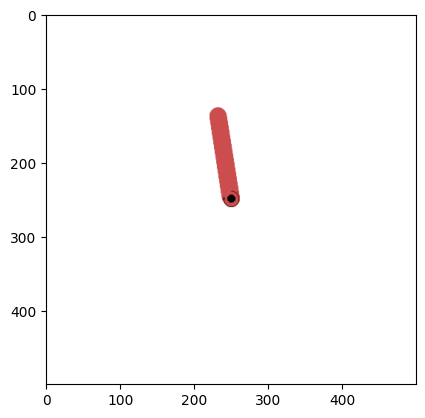

-6.931199115904614

In [21]:
test(play=True)